# T5 Model

## Data Preprocessing

In [ ]:
import os
import pandas as pd
from datasets import Dataset
from sklearn.model_selection import train_test_split
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
import torch

# Initialize a LabelEncoder
label_encoder = LabelEncoder()

# Load data
data_dir = "/content/drive/MyDrive/Data_Project"  
photos_df = pd.read_csv(os.path.join(data_dir, "photos.tsv000"), sep="\t")
keywords_df = pd.read_csv(os.path.join(data_dir, "keywords.tsv000"), sep="\t")

# Merge data for visualization and preprocessing
merged_df = pd.merge(photos_df, keywords_df, on="photo_id", how="inner")
print(f"Data Loaded: {len(merged_df)} rows")

def preprocess_data(df, sample_size=1000):
    """
    PReprocessing data to reduce size.
    """
    return df.sample(sample_size, random_state=42)

preprocessed_df = preprocess_data(merged_df)

#preprocessed_df contains 'photo_description' and 'keyword' columns
preprocessed_df = preprocessed_df.dropna(subset=['photo_description', 'keyword']).reset_index(drop=True)

# Preparing dataset by mapping 'photo_description' as input and 'keyword' as the label
train_df, test_df = train_test_split(preprocessed_df[['photo_description', 'keyword']], test_size=0.2, random_state=42)

train_df.rename(columns={'photo_description': 'input_text', 'keyword': 'label'}, inplace=True)
test_df.rename(columns={'photo_description': 'input_text', 'keyword': 'label'}, inplace=True)

train_df['label'] = label_encoder.fit_transform(train_df['label'])

def handle_unknown_labels(label):
    """ 
    Create a mapping for unseen labels in the test set.
    """
    try:
        return label_encoder.transform([label])[0]  
    except ValueError:  
        return len(label_encoder.classes_) 

test_df['label'] = test_df['label'].apply(handle_unknown_labels)

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Load pre-trained T5 tokenizer from Hugging Face
tokenizer = T5Tokenizer.from_pretrained("t5-small")

def preprocess_text(examples):
    """
    Tokenizes input texts and labels, ensuring correct padding and truncation for model training.
    """
    input_texts = examples["input_text"]
    labels = [str(label) for label in examples["label"]]  
    
    model_inputs = tokenizer(input_texts, padding="max_length", truncation=True, max_length=128, return_tensors="pt")

    labels_tokenized = tokenizer(labels, padding="max_length", truncation=True, max_length=32, return_tensors="pt")

    model_inputs["labels"] = labels_tokenized["input_ids"]

    model_inputs["attention_mask"] = model_inputs["attention_mask"]

    return {k: v.squeeze() for k, v in model_inputs.items()}

train_dataset = train_dataset.map(preprocess_text, batched=True)
test_dataset = test_dataset.map(preprocess_text, batched=True)

print("First example from train dataset:")
print(train_dataset[0])

input_ids_tensor = torch.tensor(train_dataset[0]["input_ids"])
labels_tensor = torch.tensor(train_dataset[0]["labels"])

print("Shape of input_ids:", input_ids_tensor.shape)
print("Shape of labels:", labels_tensor.shape)

Data Loaded: 2706955 rows


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/78 [00:00<?, ? examples/s]

First example from train dataset:
{'input_text': 'Flowers', 'label': 132, '__index_level_0__': 237, 'input_ids': [20294, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': [3, 23757, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

## Model 1 (Without Hyperparameters)

In [ ]:
import os
import matplotlib.pyplot as plt
from transformers import Trainer, TrainingArguments, T5ForConditionalGeneration, EarlyStoppingCallback
from torch import tensor

#output directory for saving model and logs
output_dir = "/content/drive/MyDrive/Data_Project/T5/output1"
logging_dir = "/content/drive/MyDrive/Data_Project/T5/logs1"

os.makedirs(output_dir, exist_ok=True)
os.makedirs(logging_dir, exist_ok=True)

class T5Model(nn.Module):
    def __init__(self, vocab_size, d_model=512, num_layers=6, num_heads=8, ff_dim=2048):
        """
        Initializes the T5 model with an encoder-decoder architecture based on the Transformer.
        It includes embedding layers, a Transformer encoder, and a decoder.
        """
        super(T5Model, self).__init__()
        
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=num_heads,
                dim_feedforward=ff_dim
            ),
            num_layers=num_layers
        )
        
        self.decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(
                d_model=d_model,
                nhead=num_heads,
                dim_feedforward=ff_dim
            ),
            num_layers=num_layers
        )
        
        self.embedding = nn.Embedding(vocab_size, d_model)  
        self.output_layer = nn.Linear(d_model, vocab_size)  
        self.layernorm = nn.LayerNorm(d_model)  
        self.dropout = nn.Dropout(0.1)  
    
    def forward(self, input_ids, attention_mask=None, labels=None):
        """
        Forward pass through the T5 model. 
        Processes input_ids through the encoder and decoder, and computes loss if labels are provided.
        """
        embedded = self.embedding(input_ids)  
        
        memory = self.encoder(embedded)  
        
        if labels is not None:
            labels_input = torch.cat([torch.zeros_like(labels[:, :1]), labels[:, :-1]], dim=1)
            labels_input = labels_input.to(input_ids.device)  
        else:
            labels_input = None
        
        if labels_input is not None:
            decoder_input = self.embedding(labels_input)
        else:
            decoder_input = None
        
        decoder_output = self.decoder(decoder_input, memory, memory_key_padding_mask=attention_mask)
        
        decoder_output = self.layernorm(decoder_output)
        decoder_output = self.dropout(decoder_output)
        
        logits = self.output_layer(decoder_output)  
        
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss(ignore_index=-100)  
            loss = loss_fct(logits.view(-1, logits.size(-1)), labels.view(-1))
        
        return logits, loss  

# Training Arguments (no hyperparameters)
training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=20,
    per_device_train_batch_size=4,
    logging_dir=logging_dir,
    logging_steps=100,
    save_steps=500,
    save_total_limit=2,
    eval_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="loss",
    save_strategy="steps",
    eval_strategy="steps",
    report_to="none",
)

#T5 Model initialization
vocab_size = len(tokenizer)  
model = T5Model(vocab_size)

# tokenizer loading
tokenizer = T5Tokenizer.from_pretrained("t5-small")

"""Early Stopping Callback with patience of 2 epochs/evaluations."""
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=2)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=lambda data: {
        'input_ids': tensor([f['input_ids'] for f in data]),
        'attention_mask': tensor([f['attention_mask'] for f in data]),
        'labels': tensor([f['labels'] for f in data]),
    },
    callbacks=[early_stopping_callback],
)

trainer.train()

model.save_pretrained("/content/drive/MyDrive/Data_Project/T5/final_t5_model_noh")
tokenizer.save_pretrained("/content/drive/MyDrive/Data_Project/T5/final_t5_tokenizer_noh")

<ipython-input-15-370a2086b862>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss,Validation Loss
100,5.273700,0.880247
200,0.767000,0.389097
300,0.292400,0.247616
400,0.219100,0.227297
500,0.202700,0.219720
600,0.197200,0.218391
700,0.194700,0.215580
800,0.188900,0.212010
900,0.188000,0.212284
1000,0.188200,0.210549


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


('/content/drive/MyDrive/Data_Project/T5/final_t5_tokenizer_noh/tokenizer_config.json',
 '/content/drive/MyDrive/Data_Project/T5/final_t5_tokenizer_noh/special_tokens_map.json',
 '/content/drive/MyDrive/Data_Project/T5/final_t5_tokenizer_noh/spiece.model',
 '/content/drive/MyDrive/Data_Project/T5/final_t5_tokenizer_noh/added_tokens.json')

## Training and Validation Loss

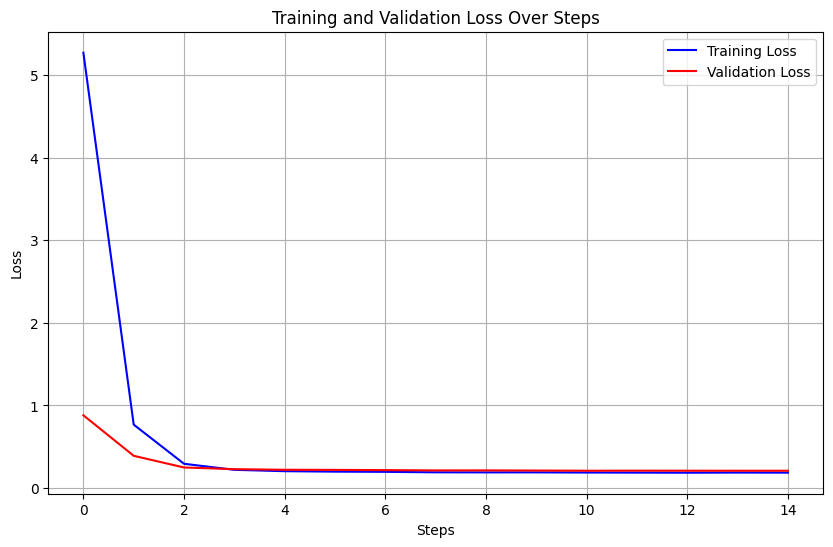

In [ ]:
import matplotlib.pyplot as plt

train_losses = []
eval_losses = []

for log in trainer.state.log_history:
    if 'loss' in log:  # Training loss
        train_losses.append(log['loss'])
    if 'eval_loss' in log:  # Validation loss
        eval_losses.append(log['eval_loss'])

plt.figure(figsize=(10, 6))

plt.plot(train_losses, label="Training Loss", color='blue')

plt.plot(eval_losses, label="Validation Loss", color='red')

plt.title("Training and Validation Loss Over Steps")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()

plt.grid(True)
plt.show()

## Test Accuracy, BLEU & Rouge Score

In [ ]:
import os
from transformers import T5ForConditionalGeneration, T5Tokenizer
from datasets import load_dataset
from nltk.translate.bleu_score import corpus_bleu
from rouge_score import rouge_scorer
import torch
import numpy as np
from collections import Counter

def token_based_accuracy(prediction, reference):
    """
    Calculate token-based accuracy by comparing the tokens in the predicted caption and the reference caption.
    The accuracy is computed as the ratio of matching tokens in the predicted caption to the total tokens in the reference caption.
    """
    predicted_tokens = set(prediction.split())  
    reference_tokens = set(reference.split())  

    intersection = predicted_tokens.intersection(reference_tokens)

    return len(intersection) / len(reference_tokens) * 100

def evaluate_model(model, tokenizer, train_dataset):
    """
    Evaluates the model by calculating various metrics including BLEU, ROUGE, token-based accuracy, and exact match accuracy.
    """
    model.eval()

    references = []
    predictions = []
    correct_predictions = 0
    total_predictions = 0
    partial_matches = 0  

    for example in train_dataset:
        input_ids = torch.tensor(example['input_ids'])
        attention_mask = torch.tensor(example['attention_mask'])
        labels = torch.tensor(example['labels'])

        outputs = model.generate(input_ids=input_ids.unsqueeze(0), attention_mask=attention_mask.unsqueeze(0), max_length=150)
        predicted_text = tokenizer.decode(outputs[0], skip_special_tokens=True)  
        reference_text = tokenizer.decode(labels, skip_special_tokens=True)  

        references.append([reference_text])
        predictions.append(predicted_text)

        partial_match = token_based_accuracy(predicted_text, reference_text)
        if partial_match > 0:  
            partial_matches += 1

        if predicted_text.strip() == reference_text.strip():
            correct_predictions += 1
        total_predictions += 1

    bleu_score = corpus_bleu(references, predictions)

    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = {"rouge1": [], "rouge2": [], "rougeL": []}
    for reference, prediction in zip(references, predictions):
        scores = scorer.score(reference[0], prediction)  
        for key in scores:
            rouge_scores[key].append(scores[key].fmeasure)

    rouge1_score = np.mean(rouge_scores['rouge1'])
    rouge2_score = np.mean(rouge_scores['rouge2'])
    rougeL_score = np.mean(rouge_scores['rougeL'])

    accuracy = (correct_predictions / total_predictions) * 100

    partial_accuracy = (partial_matches / total_predictions) * 100

    return bleu_score, rouge1_score, rouge2_score, rougeL_score, accuracy, partial_accuracy, references, predictions

bleu, rouge1, rouge2, rougeL, accuracy, partial_accuracy, references, predictions = evaluate_model(model, tokenizer, test_dataset)

print(f"BLEU Score: {bleu}")
print(f"ROUGE-1 F1: {rouge1}")
print(f"ROUGE-2 F1: {rouge2}")
print(f"ROUGE-L F1: {rougeL}")
print(f"Exact Match Accuracy: {accuracy:.2f}%")
print(f"Partial Match Accuracy: {partial_accuracy:.2f}%")

for i in range(5):  
    print(f"\nExample {i + 1}:")
    print(f"Input: {test_dataset[i]['input_text']}")
    print(f"Reference: {references[i][0]}")
    print(f"Prediction: {predictions[i]}")

BLEU Score: 1.6804529019622661e-78
ROUGE-1 F1: 0.022653721682847898
ROUGE-2 F1: 0.0
ROUGE-L F1: 0.022653721682847898
Exact Match Accuracy: 2.27%
Partial Match Accuracy: 2.27%

Example 1:
Input: Stargazing
Reference: 132
Prediction: 82

Example 2:
Input: horse
Reference: 209
Prediction: 119

Example 3:
Input: Leaves and dew
Reference: 124
Prediction: 119

Example 4:
Input: Follow me on Instagram @thomasofnorth
Reference: 191
Prediction: 139

Example 5:
Input: Just before going to class and running over it with my tire a had to take a photo of this fungus!
Reference: 250
Prediction: 113


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


## Model 2 (With Hyperparameters) - (Learning Rate 3e-5, Gradient Clipping) 

In [ ]:
import os
import matplotlib.pyplot as plt
from transformers import Trainer, TrainingArguments, T5ForConditionalGeneration, EarlyStoppingCallback
from torch import tensor

output_dir = "/content/drive/MyDrive/Data_Project/T5/output"  
logging_dir = "/content/drive/MyDrive/Data_Project/T5/logs"

os.makedirs(output_dir, exist_ok=True)
os.makedirs(logging_dir, exist_ok=True)

# Training Arguments with learning rate and additional hyperparameters
training_args_p = TrainingArguments(
    output_dir=output_dir,             
    num_train_epochs=20,               
    per_device_train_batch_size=4,     
    per_device_eval_batch_size=4,      
    warmup_steps=500,                  
    weight_decay=0.01,                 
    logging_dir=logging_dir,           
    logging_steps=100,                 
    save_steps=500,                    
    save_total_limit=2,                
    eval_steps=100,                    
    prediction_loss_only=True,         
    load_best_model_at_end=True,       
    metric_for_best_model="loss",      
    report_to="none",                  
    save_strategy="steps",             
    eval_strategy="steps",             
    learning_rate=3e-5,                
    adam_epsilon=1e-8,                 
    max_grad_norm=1.0,                 
    lr_scheduler_type="linear",        
)

# T5 Model inialization
vocab_size = len(tokenizer)  
model_p = T5Model(vocab_size)

# tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-small")

# early stopping
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=2  
)

trainer_p = Trainer(
    model=model_p,                          
    args=training_args_p,                   
    train_dataset=train_dataset,          
    eval_dataset=test_dataset,            
    tokenizer=tokenizer,                  
    data_collator=lambda data: {
        'input_ids': tensor([f['input_ids'] for f in data]),
        'attention_mask': tensor([f['attention_mask'] for f in data]),
        'labels': tensor([f['labels'] for f in data]),
    },                                    
    callbacks=[early_stopping_callback],  
)

trainer_p.train()

model_p.save_pretrained("/content/drive/MyDrive/Data_Project/T5/final_t5_model")
tokenizer.save_pretrained("/content/drive/MyDrive/Data_Project/T5/final_t5_tokenizer")

<ipython-input-28-66050b2ee670>:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss
100,15.180000,12.089178
200,9.228300,3.071152
300,2.589900,0.869223
400,0.829600,0.391412
500,0.285900,0.238567
600,0.211000,0.229563
700,0.199000,0.221216
800,0.191100,0.213971
900,0.188900,0.213531
1000,0.187900,0.214342


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


('/content/drive/MyDrive/Data_Project/T5/final_t5_tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/Data_Project/T5/final_t5_tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/Data_Project/T5/final_t5_tokenizer/spiece.model',
 '/content/drive/MyDrive/Data_Project/T5/final_t5_tokenizer/added_tokens.json')

## Training and Validation Loss

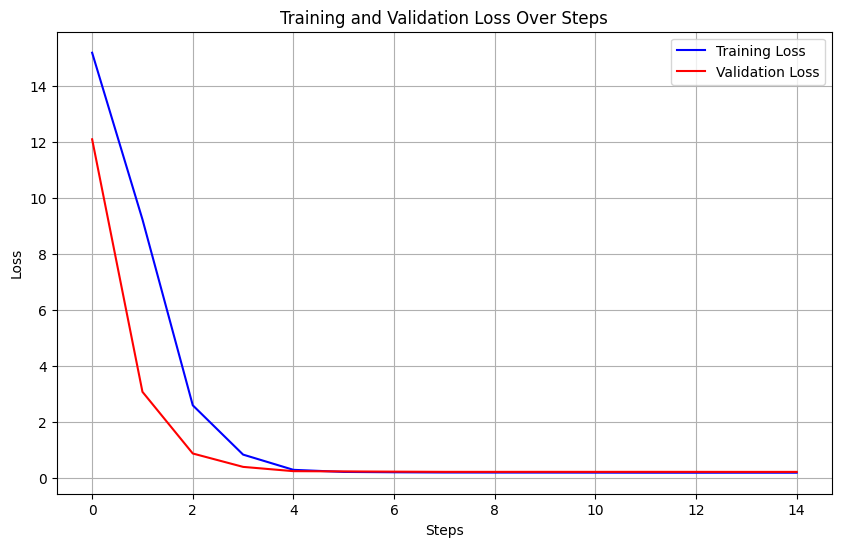

In [ ]:
import matplotlib.pyplot as plt

train_losses = []
eval_losses = []

for log in trainer.state.log_history:
    if 'loss' in log:  # Training loss
        train_losses.append(log['loss'])
    if 'eval_loss' in log:  # Validation loss
        eval_losses.append(log['eval_loss'])

plt.figure(figsize=(10, 6))

plt.plot(train_losses, label="Training Loss", color='blue')

plt.plot(eval_losses, label="Validation Loss", color='red')

plt.title("Training and Validation Loss Over Steps")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()

plt.grid(True)
plt.show()

## Test Accuracy

In [ ]:
import os
from transformers import T5ForConditionalGeneration, T5Tokenizer
from datasets import load_dataset
from nltk.translate.bleu_score import corpus_bleu
from rouge_score import rouge_scorer
import torch
import numpy as np
from collections import Counter

bleu, rouge1, rouge2, rougeL, accuracy, partial_accuracy, references, predictions = evaluate_model(model, tokenizer, test_dataset)

print(f"BLEU Score: {bleu}")
print(f"ROUGE-1 F1: {rouge1}")
print(f"ROUGE-2 F1: {rouge2}")
print(f"ROUGE-L F1: {rougeL}")
print(f"Exact Match Accuracy: {accuracy:.2f}%")
print(f"Partial Match Accuracy: {partial_accuracy:.2f}%")

for i in range(5):  
    print(f"\nExample {i + 1}:")
    print(f"Input: {test_dataset[i]['input_text']}")
    print(f"Reference: {references[i][0]}")
    print(f"Prediction: {predictions[i]}")

BLEU Score: 1.7975756794025036e-78
ROUGE-1 F1: 0.02912621359223301
ROUGE-2 F1: 0.0
ROUGE-L F1: 0.02912621359223301
Exact Match Accuracy: 2.91%
Partial Match Accuracy: 2.91%

Example 1:
Input: Stargazing
Reference: 132
Prediction: 82

Example 2:
Input: horse
Reference: 209
Prediction: 119

Example 3:
Input: Leaves and dew
Reference: 124
Prediction: 119

Example 4:
Input: Follow me on Instagram @thomasofnorth
Reference: 191
Prediction: 139

Example 5:
Input: Just before going to class and running over it with my tire a had to take a photo of this fungus!
Reference: 250
Prediction: 113


## Model 3 (Epochs = 20, Learning Rate = 5e-5, Regularization, Gradient Clipping, Adam Optimizer)

In [ ]:
import os
import torch
from torch import nn
from transformers import Trainer, TrainingArguments, T5Tokenizer, EarlyStoppingCallback
from torch.optim import AdamW
from datasets import Dataset

output_dir = "/content/drive/MyDrive/Data_Project/T5/output"  
logging_dir = "/content/drive/MyDrive/Data_Project/T5/logs"

os.makedirs(output_dir, exist_ok=True)
os.makedirs(logging_dir, exist_ok=True)

# Training Arguments with regularization (weight decay) and additional hyperparameters
training_args_p2 = TrainingArguments(
    output_dir=output_dir,             
    num_train_epochs=20,               
    per_device_train_batch_size=4,     
    per_device_eval_batch_size=4,      
    warmup_steps=500,                  
    weight_decay=0.01,                 
    logging_dir=logging_dir,           
    logging_steps=100,                  
    save_steps=500,                    
    save_total_limit=2,                
    eval_steps=100,                     
    prediction_loss_only=True,         
    load_best_model_at_end=True,       
    metric_for_best_model="eval_loss", 
    report_to="none",                  
    save_strategy="steps",             
    eval_strategy="steps",             

    learning_rate=5e-5,                
    adam_epsilon=1e-8,                 
    max_grad_norm=0.5,                 
    lr_scheduler_type="linear",        
    fp16=True                          
)

def data_collator(batch):
    """
    Data Collator for batching,
    """
    return {
        'input_ids': torch.tensor([f['input_ids'] for f in batch]),
        'attention_mask': torch.tensor([f['attention_mask'] for f in batch]),
        'labels': torch.tensor([f['labels'] for f in batch]),
    }

early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=2  
)

#T5 Model
vocab_size = len(tokenizer)  
model_p2 = T5Model(vocab_size)

#tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-small")

trainer_p2 = Trainer(
    model=model_p2,                          
    args=training_args_p2,                   
    train_dataset=train_dataset,          
    eval_dataset=test_dataset,            
    tokenizer=tokenizer,                  
    data_collator=data_collator,          
    callbacks=[early_stopping_callback],  
)

trainer_p2.train()

model_p.save_pretrained("/content/drive/MyDrive/Data_Project/T5/final_t5_model")
tokenizer.save_pretrained("/content/drive/MyDrive/Data_Project/T5/final_t5_tokenizer")

<ipython-input-15-58f7bb097d97>:62: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss
100,15.606100,13.456785
200,11.875000,7.478420
300,5.550800,1.470448
400,1.910100,0.825931
500,0.838300,0.459506
600,0.360400,0.262034
700,0.236400,0.238818
800,0.211900,0.230182
900,0.203700,0.226151
1000,0.201300,0.222391


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


('/content/drive/MyDrive/Data_Project/T5/final_t5_tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/Data_Project/T5/final_t5_tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/Data_Project/T5/final_t5_tokenizer/spiece.model',
 '/content/drive/MyDrive/Data_Project/T5/final_t5_tokenizer/added_tokens.json')

## Training and Validation Loss

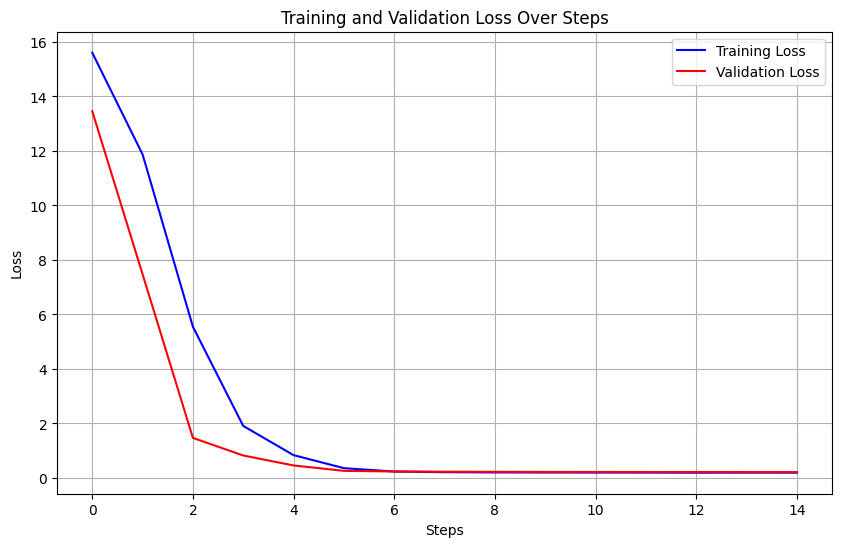

In [ ]:
import matplotlib.pyplot as plt

train_losses = []
eval_losses = []

for log in trainer_p2.state.log_history:
    if 'loss' in log:  # Training loss
        train_losses.append(log['loss'])
    if 'eval_loss' in log:  # Validation loss
        eval_losses.append(log['eval_loss'])

plt.figure(figsize=(10, 6))

plt.plot(train_losses, label="Training Loss", color='blue')

plt.plot(eval_losses, label="Validation Loss", color='red')

plt.title("Training and Validation Loss Over Steps")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()

plt.grid(True)
plt.show()

## Test Accuracy

In [ ]:
import os
from transformers import T5ForConditionalGeneration, T5Tokenizer
from datasets import load_dataset
from nltk.translate.bleu_score import corpus_bleu
from rouge_score import rouge_scorer
import torch
import numpy as np
from collections import Counter

bleu, rouge1, rouge2, rougeL, accuracy, partial_accuracy, references, predictions = evaluate_model(model, tokenizer, test_dataset)

print(f"BLEU Score: {bleu}")
print(f"ROUGE-1 F1: {rouge1}")
print(f"ROUGE-2 F1: {rouge2}")
print(f"ROUGE-L F1: {rougeL}")
print(f"Exact Match Accuracy: {accuracy:.2f}%")
print(f"Partial Match Accuracy: {partial_accuracy:.2f}%")

for i in range(5):  
    print(f"\nExample {i + 1}:")
    print(f"Input: {test_dataset[i]['input_text']}")
    print(f"Reference: {references[i][0]}")
    print(f"Prediction: {predictions[i]}")

BLEU Score: 1.1155940311545666e-78
ROUGE-1 F1: 0.006472491909385114
ROUGE-2 F1: 0.0
ROUGE-L F1: 0.006472491909385114
Exact Match Accuracy: 0.65%
Partial Match Accuracy: 0.65%

Example 1:
Input: Stargazing
Reference: 132
Prediction: 147

Example 2:
Input: horse
Reference: 209
Prediction: 147

Example 3:
Input: Leaves and dew
Reference: 124
Prediction: 119

Example 4:
Input: Follow me on Instagram @thomasofnorth
Reference: 191
Prediction: 139

Example 5:
Input: Just before going to class and running over it with my tire a had to take a photo of this fungus!
Reference: 250
Prediction: 233


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


## Model 4 (Momentum = 0.8)

In [ ]:
import os
import matplotlib.pyplot as plt
from transformers import Trainer, TrainingArguments, T5ForConditionalGeneration, EarlyStoppingCallback
from torch import tensor
import torch.optim as optim

output_dir = "/content/drive/MyDrive/Data_Project/T5/output"  
logging_dir = "/content/drive/MyDrive/Data_Project/T5/logs"

os.makedirs(output_dir, exist_ok=True)
os.makedirs(logging_dir, exist_ok=True)

# Training Arguments with Momentum = 0.8
training_args_m1 = TrainingArguments(
    output_dir=output_dir,             
    num_train_epochs=20,               
    per_device_train_batch_size=4,     
    per_device_eval_batch_size=4,      
    warmup_steps=500,                  
    weight_decay=0.01,                 
    logging_dir=logging_dir,           
    logging_steps=100,                 
    save_steps=500,                    
    save_total_limit=2,                
    eval_steps=100,                    
    prediction_loss_only=True,        
    load_best_model_at_end=True,       
    metric_for_best_model="loss",      
    report_to="none",                  
    save_strategy="steps",             
    eval_strategy="steps",             
    learning_rate=3e-5,                
    adam_epsilon=1e-8,                 
    max_grad_norm=1.0,                 
    lr_scheduler_type="linear",        
)

# T5 model
vocab_size = len(tokenizer)  
model_m1 = T5Model(vocab_size)

# Tokenizer 
tokenizer = T5Tokenizer.from_pretrained("t5-small")

early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=5  
)

# SGD optimizer with momentum value 0.8
optimizer = optim.SGD(model.parameters(), lr=training_args.learning_rate, momentum=0.8)

trainer_m8 = Trainer(
    model=model_m1,                          
    args=training_args_m1,                   
    train_dataset=train_dataset,         
    eval_dataset=test_dataset,            
    tokenizer=tokenizer,                  
    data_collator=lambda data: {
        'input_ids': tensor([f['input_ids'] for f in data]),
        'attention_mask': tensor([f['attention_mask'] for f in data]),
        'labels': tensor([f['labels'] for f in data]),
    },                                    
    callbacks=[early_stopping_callback],  
    optimizers=(optimizer, None),         
)

trainer_m8.train()

model_m1.save_pretrained("/content/drive/MyDrive/Data_Project/T5/final_t5_model_momentum_0.8")
tokenizer.save_pretrained("/content/drive/MyDrive/Data_Project/T5/final_t5_tokenizer_momentum_0.8")

<ipython-input-23-484af051848c>:52: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_m8 = Trainer(


Step,Training Loss,Validation Loss
100,16.249700,15.686395
200,16.149400,15.562390
300,15.731300,15.310379
400,15.804200,14.998670
500,15.028200,14.534626
600,15.207500,14.072302
700,14.506800,13.596445
800,14.281200,13.249656
900,14.055500,12.887032
1000,13.252900,12.565821


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


('/content/drive/MyDrive/Data_Project/T5/final_t5_tokenizer_momentum_0.8/tokenizer_config.json',
 '/content/drive/MyDrive/Data_Project/T5/final_t5_tokenizer_momentum_0.8/special_tokens_map.json',
 '/content/drive/MyDrive/Data_Project/T5/final_t5_tokenizer_momentum_0.8/spiece.model',
 '/content/drive/MyDrive/Data_Project/T5/final_t5_tokenizer_momentum_0.8/added_tokens.json')

## Training and Validation Loss

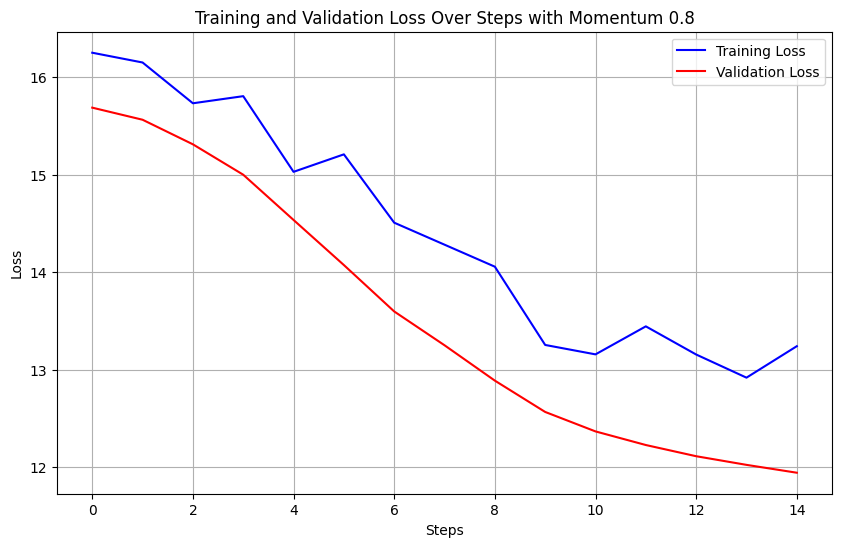

In [ ]:
import matplotlib.pyplot as plt

train_losses = []
eval_losses = []

for log in trainer_m8.state.log_history:
    if 'loss' in log:  # Training loss
        train_losses.append(log['loss'])
    if 'eval_loss' in log:  # Validation loss
        eval_losses.append(log['eval_loss'])

plt.figure(figsize=(10, 6))

plt.plot(train_losses, label="Training Loss", color='blue')

plt.plot(eval_losses, label="Validation Loss", color='red')

plt.title("Training and Validation Loss Over Steps with Momentum 0.8")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()

plt.grid(True)
plt.show()

## Test Accuracy

In [ ]:
import os
from transformers import T5ForConditionalGeneration, T5Tokenizer
from datasets import load_dataset
from nltk.translate.bleu_score import corpus_bleu
from rouge_score import rouge_scorer
import torch
import numpy as np
from collections import Counter

bleu, rouge1, rouge2, rougeL, accuracy, partial_accuracy, references, predictions = evaluate_model(model, tokenizer, test_dataset)

print(f"BLEU Score: {bleu}")
print(f"ROUGE-1 F1: {rouge1}")
print(f"ROUGE-2 F1: {rouge2}")
print(f"ROUGE-L F1: {rougeL}")
print(f"Exact Match Accuracy: {accuracy:.2f}%")
print(f"Partial Match Accuracy: {partial_accuracy:.2f}%")

for i in range(5):  
    print(f"\nExample {i + 1}:")
    print(f"Input: {test_dataset[i]['input_text']}")
    print(f"Reference: {references[i][0]}")
    print(f"Prediction: {predictions[i]}")

BLEU Score: 3.172418064917688e-156
ROUGE-1 F1: 0.0
ROUGE-2 F1: 0.0
ROUGE-L F1: 0.0
Exact Match Accuracy: 0.00%
Partial Match Accuracy: 0.00%

Example 1:
Input: Stargazing
Reference: 132
Prediction: Flowers

Example 2:
Input: horse
Reference: 209
Prediction: Diamond beach Iceland

Example 3:
Input: Leaves and dew
Reference: 124
Prediction: dessert plant

Example 4:
Input: Follow me on Instagram @thomasofnorth
Reference: 191
Prediction: Ich habe das Foto durch eine Windbreak auf der Bergstation von Sass Pordoi gefahren!

Example 5:
Input: Just before going to class and running over it with my tire a had to take a photo of this fungus!
Reference: 250
Prediction: @ultrabrad @ultrabrad | McCall Idaho


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


# Model 4 (Momentum = 0.5)

In [ ]:
import os
import matplotlib.pyplot as plt
from transformers import Trainer, TrainingArguments, T5ForConditionalGeneration, EarlyStoppingCallback
from torch import tensor
import torch.optim as optim

output_dir = "/content/drive/MyDrive/Data_Project/T5/output"  
logging_dir = "/content/drive/MyDrive/Data_Project/T5/logs"

os.makedirs(output_dir, exist_ok=True)
os.makedirs(logging_dir, exist_ok=True)

# Training Arguments with Momentum value = 0.5
training_args_m2 = TrainingArguments(
    output_dir=output_dir,             
    num_train_epochs=20,               
    per_device_train_batch_size=4,     
    per_device_eval_batch_size=4,      
    warmup_steps=500,                  
    weight_decay=0.01,                 
    logging_dir=logging_dir,           
    logging_steps=100,                 
    save_steps=500,                    
    save_total_limit=2,                
    eval_steps=100,                    
    prediction_loss_only=True,         
    load_best_model_at_end=True,       
    metric_for_best_model="loss",      
    report_to="none",                  
    save_strategy="steps",             
    eval_strategy="steps",             
    learning_rate=1e-5,                
    adam_epsilon=1e-8,                 
    max_grad_norm=1.0,                 
    lr_scheduler_type="linear",        
)

# T5 model
vocab_size = len(tokenizer)  
model_m2 = T5Model(vocab_size)

# tokenizer 
tokenizer = T5Tokenizer.from_pretrained("t5-small")

early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=5  
)

# SGD optimizer with momentum value 0.5
optimizer = optim.SGD(model.parameters(), lr=training_args.learning_rate, momentum=0.5)

trainer_m5 = Trainer(
    model=model_m2,                         
    args=training_args_m2,                   
    train_dataset=train_dataset,          
    eval_dataset=test_dataset,            
    tokenizer=tokenizer,                  
    data_collator=lambda data: {
        'input_ids': tensor([f['input_ids'] for f in data]),
        'attention_mask': tensor([f['attention_mask'] for f in data]),
        'labels': tensor([f['labels'] for f in data]),
    },                                    
    callbacks=[early_stopping_callback],  
    optimizers=(optimizer, None),         
)

trainer_m5.train()

model_m2.save_pretrained("/content/drive/MyDrive/Data_Project/T5/final_t5_model_momentum_0.5")
tokenizer.save_pretrained("/content/drive/MyDrive/Data_Project/T5/final_t5_tokenizer_momentum_0.5")

<ipython-input-20-6cb262ea3200>:52: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_m5 = Trainer(


Step,Training Loss,Validation Loss
100,16.257800,15.725364
200,16.224200,15.708938
300,15.938900,15.674856
400,16.177500,15.631700
500,15.667800,15.584060
600,16.145600,15.528934
700,15.793800,15.477398
800,15.860000,15.429515
900,15.841700,15.389201
1000,15.372600,15.350088


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


('/content/drive/MyDrive/Data_Project/T5/final_t5_tokenizer_momentum_0.5/tokenizer_config.json',
 '/content/drive/MyDrive/Data_Project/T5/final_t5_tokenizer_momentum_0.5/special_tokens_map.json',
 '/content/drive/MyDrive/Data_Project/T5/final_t5_tokenizer_momentum_0.5/spiece.model',
 '/content/drive/MyDrive/Data_Project/T5/final_t5_tokenizer_momentum_0.5/added_tokens.json')

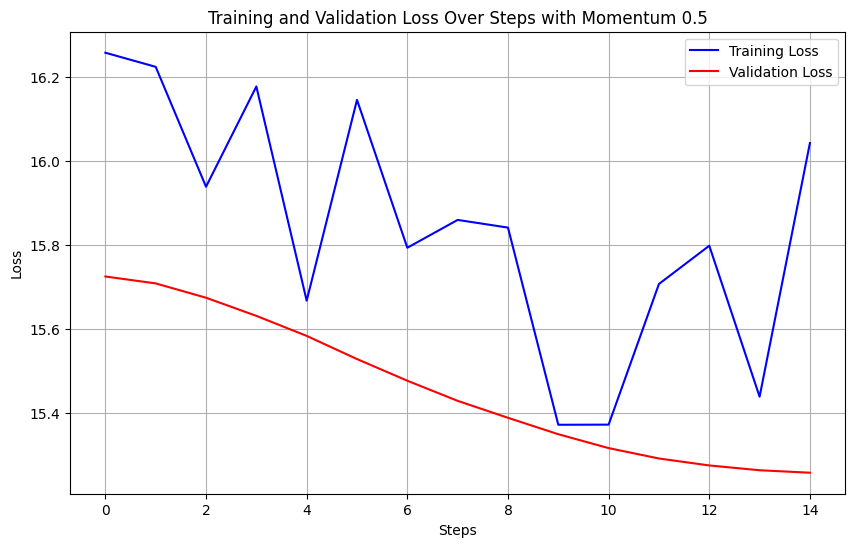

In [ ]:
import matplotlib.pyplot as plt

train_losses = []
eval_losses = []

for log in trainer_m5.state.log_history:
    if 'loss' in log:  # Training loss
        train_losses.append(log['loss'])
    if 'eval_loss' in log:  # Validation loss
        eval_losses.append(log['eval_loss'])

plt.figure(figsize=(10, 6))

plt.plot(train_losses, label="Training Loss", color='blue')

plt.plot(eval_losses, label="Validation Loss", color='red')

plt.title("Training and Validation Loss Over Steps with Momentum 0.5")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()

plt.grid(True)
plt.show()

In [ ]:
import os
from transformers import T5ForConditionalGeneration, T5Tokenizer
from datasets import load_dataset
from nltk.translate.bleu_score import corpus_bleu
from rouge_score import rouge_scorer
import torch
import numpy as np
from collections import Counter

bleu, rouge1, rouge2, rougeL, accuracy, partial_accuracy, references, predictions = evaluate_model(model, tokenizer, test_dataset)

print(f"BLEU Score: {bleu}")
print(f"ROUGE-1 F1: {rouge1}")
print(f"ROUGE-2 F1: {rouge2}")
print(f"ROUGE-L F1: {rougeL}")
print(f"Exact Match Accuracy: {accuracy:.2f}%")
print(f"Partial Match Accuracy: {partial_accuracy:.2f}%")

for i in range(5):  
    print(f"\nExample {i + 1}:")
    print(f"Input: {test_dataset[i]['input_text']}")
    print(f"Reference: {references[i][0]}")
    print(f"Prediction: {predictions[i]}")

BLEU Score: 3.309154875135366e-156
ROUGE-1 F1: 0.0
ROUGE-2 F1: 0.0
ROUGE-L F1: 0.0
Exact Match Accuracy: 0.00%
Partial Match Accuracy: 0.00%

Example 1:
Input: Stargazing
Reference: 132
Prediction: Flowers

Example 2:
Input: horse
Reference: 209
Prediction: Diamond beach Iceland

Example 3:
Input: Leaves and dew
Reference: 124
Prediction: dessert plant

Example 4:
Input: Follow me on Instagram @thomasofnorth
Reference: 191
Prediction: Ich habe das Foto durch eine Windbreak auf der Bergstation von Sass Pordoi erworben!

Example 5:
Input: Just before going to class and running over it with my tire a had to take a photo of this fungus!
Reference: 250
Prediction: @ultrabrad @ultrabrad | McCall Idaho


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
